# Univariate multi-step CNN modelling with Keras

In [45]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


## Data preparation phase - Dataset: number of COVID-19 infections per day

In the following lines the dataset is pre-processed, were the cumulative sums are transformed to their original values. The relevant data is than aggregated to daily sums of the number of corona virus infections per day. Also the train and test sets are defined. 

In [46]:
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot as plt


In [47]:
dutch_data_01 = pd.read_csv('/Users/stevenkraamwinkel/Desktop/Datasets 1 mei/COVID-19_aantallen_gemeente_cumulatief_01_05.csv', parse_dates=True, delimiter=';')
display(dutch_data_01)


,Date_of_report,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased
0,13/03/2020 10:00,GM0003,Appingedam,Groningen,0,0,0
1,13/03/2020 10:00,GM0010,Delfzijl,Groningen,0,0,0
2,13/03/2020 10:00,GM0014,Groningen,Groningen,3,0,0
3,13/03/2020 10:00,GM0024,Loppersum,Groningen,0,0,0
4,13/03/2020 10:00,GM0034,Almere,Flevoland,1,1,0
...,...,...,...,...,...,...,...
151955,01/05/2021 10:00,NaN,NaN,Noord-Holland,668,20,2
151956,01/05/2021 10:00,NaN,NaN,Zuid-Holland,2312,46,15
151957,01/05/2021 10:00,NaN,NaN,Zeeland,56,4,1
151958,01/05/2021 10:00,NaN,NaN,Noord-Brabant,1144,29,7


In [48]:
covid_data = dutch_data_01.loc[:,('Date_of_report', 'Total_reported', 'Hospital_admission', 'Deceased')]
covid_data['Date_of_report']= pd.to_datetime(covid_data['Date_of_report'], format='%d/%m/%Y %H:%M')
covid_data = covid_data.set_index('Date_of_report')
covid_data.loc[covid_data.index!='Date_of_report'].sum()
covid_data = covid_data.resample('D').sum()


In [49]:
cumulative = covid_data['Total_reported']

def B(cumulative):
    output = [0] * len(cumulative)
    for i,e in reversed(list(enumerate(cumulative))):
        output[i]=cumulative[i] - cumulative[i-1]
    output[0]=cumulative[0]
    return output


In [50]:
input_data = pd.DataFrame(B(cumulative), index = pd.date_range('03/13/2020', '05/01/2021'), columns = {'Infections_per_day'})
display(input_data)


,Infections_per_day
2020-03-13,804
2020-03-14,155
2020-03-15,176
2020-03-16,278
2020-03-17,292
...,...
2021-04-27,5337
2021-04-28,8649
2021-04-29,7271
2021-04-30,7758


In [51]:
# Defining the train and test set

train = input_data[19:325] # april 2020 - feb 2020
test = input_data[325:414] # feb 2021, april 2021


## 1-D sequential CNN forecasting - Vector output model

The CNN model that is implemented and makes forecasts on the number of corona virus infections over the time interval 1 february 2021 - 30 april 2021, is a one-dimensional vector output CNN model. This essentially means, that the 1-D input sequence is translated into a forecasted 1-D output vector containing the forecasting values. 

In [52]:
#The following model below has been modified from source: 
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/


# 1-D CNN VECTOR OUTPUT MODEL

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


Running the following code will make the CNN model make predictions on the number of corona virus infections over the time interval 1 february 2021 - 30 april 2021.
This process takes a few seconds, but in many cases no more than 30 seconds. 

In [53]:
# define input sequence
data_seq = input_data
# choose a number of time steps
n_steps_in, n_steps_out = 306, 89
# split into samples
X, y = split_sequence(data_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array(train)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[3184.7812 3831.4956 3940.0916 4384.8438 4583.8193 3639.327  3077.1414
  2615.5137 2287.339  3412.069  4515.965  4389.611  4081.7268 3272.6487
  2775.2454 2365.2136 3423.3276 4519.769  4625.0303 4696.5347 4717.5605
  4026.2698 3365.8196 4199.3887 5451.437  5353.0654 5472.017  4739.0186
  4123.056  3868.5818 4216.1895 4974.3813 4818.358  5294.8926 4513.1855
  3834.892  4172.162  4447.4736 5016.833  6314.245  6129.5703 6023.2944
  5485.765  4999.661  5904.918  6695.76   7255.0103 7278.491  6615.7705
  5929.715  6015.818  7249.7866 7693.9814 7733.6807 8161.0723 7389.758
  6667.8623 6581.198  7445.3506 7586.826  7864.201  7785.1836 6703.1323
  5303.776  5258.497  6492.551  7339.591  7831.7886 7903.5054 7708.877
  6404.31   6069.9478 6643.9004 8073.3076 9075.249  8155.2646 8224.226
  7450.781  7020.329  8097.8423 9518.374  9145.193  8371.415  8066.568
  7174.1826 5898.6274 7596.505  7627.765  7690.036 ]]


The forecasts produced by the CNN model are considered to be approximations according to an optimization procedure, that is averaged over all training epochs. Since each predicted value is an average over all training epochs, the predicted number is a floating point number, which is different from the input, that contains only whole integer numbers. 

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 305, 64)           192       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 152, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                486450    
_________________________________________________________________
dense_7 (Dense)              (None, 89)                4539      
Total params: 491,181
Trainable params: 491,181
Non-trainable params: 0
_________________________________________________________________


In [55]:
#Convert the resulting array into a 1-column dataframe
cnn_dataframe = pd.DataFrame(yhat)
cnn_dataframe = cnn_dataframe.transpose()


In [56]:
# Add datetime index to dataframe for plotting the data
cnn_dataframe['date'] = pd.date_range(start='02/01/2021', periods=len(cnn_dataframe), freq='D') 
cnn_dataframe = cnn_dataframe.set_index('date')


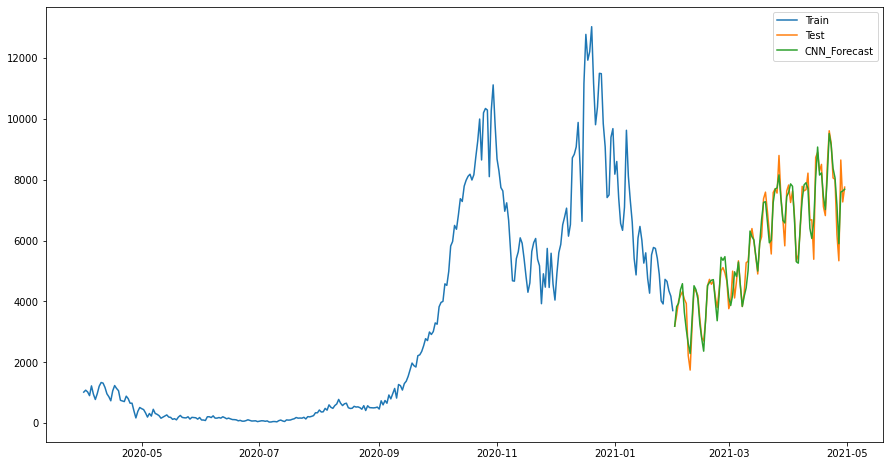

In [57]:
# Forecasting plot
# Code of CNN model plot modified from source: 
# https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/?#

plt.figure(figsize=(15,8))
plt.plot(train['Infections_per_day'], label='Train')
plt.plot(test['Infections_per_day'], label='Test')
plt.plot(cnn_dataframe, label='CNN_Forecast')
plt.legend(loc='best')
plt.show()

## Performance measures

Similar to all classical machine learning models, that have been implemented earlier. The performance metrics of the CNN 1-D vector model are the root mean-squared error (RMSE) and the mean average error (MAE). Results may vary, but in most runs both metrics show values between 300 and 600, whereas the MAE value is lower than the RMSE value. 

In [58]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from math import sqrt


In [59]:
rmse = sqrt(mean_squared_error(test, cnn_dataframe))
print(rmse)

392.5576015131093


In [60]:
mae = mean_absolute_error(test, cnn_dataframe)
print(mae)

290.4668462517556


END OF NOTEBOOK, VERSION: 25TH of JUNE, 2021. TIME SERIES MODELLING 3 
